# Reproducing figures 9 & 10 from the paper

In the paper, we show that proper motion can have a major impact on the detectability of clusters. This notebook presents a quick way to reproduce these figures as an example. By default, the figures use a lower resolution - this makes them a lot quicker to generate.

`⚠️ This notebook requires 8 GB+ of disk space to run, as it will need to download the Zucker+25 dust map.`

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import hashlib
import warnings
from dustmaps.bayestar import BayestarWebQuery
from dustmaps.decaps import DECaPSQueryLite
import dustmaps.decaps
from astropy.coordinates import (
    SkyCoord,
    CylindricalDifferential,
    CylindricalRepresentation,
)
from astropy import units as u
from gala.potential import MilkyWayPotential2022
from pathlib import Path
from hr_selection_function import HR24SelectionFunction, NStarsPredictor

## Make a query grid and grab dust

To start with, we need to look up extinction on a grid in the Milky Way.

`⚠️ This will download the Zucker+25 dust map, which takes 8 GB+ of disk space.`

In [2]:
# Whether or not to allow a predefined cache file to be used. This will speed up your
# code if you run it multiple times, but if you change other settings about the grid,
# then you might need to switch off the cache file system.
allow_cache_file = True

# Define grid parameters
res = 50  # 250 in the paper (reduced for runtime improvement)
z_res = 7  # 11 in the paper (reduced for runtime improvement)

# Setup the grid
x_grid = np.linspace(-13000, -3000, num=res)
y_grid = np.linspace(-5000, 5000, num=res)
z_grid = np.linspace(-100, 100, num=z_res)

In [ ]:
# Make a unique ID based on the defined grid, which lets us know easily if any settings
# have changed
unique_hash = hashlib.md5(np.concatenate([x_grid, y_grid, z_grid])).hexdigest()
cache_file = Path(f".cache/extinction_grid_{unique_hash}.parquet")

if cache_file.exists() and allow_cache_file:
    points = pd.read_parquet(cache_file)
else:
    print(
        "No cache file found for these settings, or cache file use disallowed; "
        "looking up extinction values for this grid."
    )
    bayestar = BayestarWebQuery()
    print("--------------------------------")
    print("Downloading Zucker+25 dust map.")
    print("WARNING: this will take at least 8 GB of disk space!")
    print("--------------------------------")
    dustmaps.decaps.fetch(mean_only=True)
    decaps = DECaPSQueryLite(mean_only=True)

    if z_res == 1:
        z_grid = np.zeros(1)

    xx, yy, zz = np.meshgrid(x_grid, y_grid, z_grid)

    x, y, z = xx.flatten(), yy.flatten(), zz.flatten()

    print(f"Number of points: {len(x)}")

    coords = SkyCoord(
        x * u.pc,
        y * u.pc,
        z * u.pc,
        frame="galactocentric",
        representation_type="cartesian",
    ).transform_to("galactic")

    points = pd.DataFrame.from_dict(
        {
            "x": x,
            "y": y,
            "z": z,
            "l": coords.l.value,
            "b": coords.b.value,
            "distance": coords.distance.value,
            "parallax": 1000 / coords.distance.value,
            "distance_modulus": 5 * np.log10(coords.distance.value) - 5,
        }
    )

    print("Performing Bayestar query...")
    points["extinction_bayestar"] = bayestar.query(coords, mode="best") * 3.1 * 0.86

    print("Performing decaps query... (this may take a WHILE)")
    points["extinction_decaps"] = decaps.query(coords) * 3.1

    print("Saving...")
    points["extinction"] = np.where(
        points["extinction_bayestar"].isna(),
        points["extinction_decaps"],
        points["extinction_bayestar"],
    )
    cache_file.parent.mkdir(exist_ok=True)
    points.to_parquet(cache_file)

No cache file found for these settings, or cache file use disallowed; looking up extinction values for this grid.
File '/home/emily/data/dustmaps/decaps/decaps_mean.h5' already exists. Skipping download. To overwrite, use clobber=True.
Loading meta pixel info...
Meta pixel info loaded!
Number of points: 17500
Performing Bayestar query...
Performing decaps query... (this may take a WHILE)
Saving...


## Query the selection function for a given cluster

Next, we need to query the selection function! Let's use a cluster with these parameters:

In [4]:
cluster_parameters = {
    "mass": 200,
    "log_age": 9.4,  # 2.5 Gyr
    "metallicity": 0.0,
    "differential_extinction": 0.0,
}

Everything else (distance, velocity, extinction, etc) will change on our grid.

### Required models

Let's instantiate the models we need. We need to pick a Galactic potential to sample velocities, use a model to predict the number of stars in each cluster, and then also initialize our selection function.

In [5]:
potential = MilkyWayPotential2022()
selection_function = HR24SelectionFunction()

# Set number of models higher for more accuracy at expense of speed
n_simulated_predictor = NStarsPredictor(models=10)

### Helpers

Before we go any further, we should define some helper functions to do things, like go from a velocity in cylindrical coordinates to an astropy SkyCoord object, or calculate what the detection probability would be end-to-end based on our model.

In [ ]:
def get_coordinates(data, v_phi_offset=0, v_rho_offset=0, v_z_offset=0):
    """Creates an astropy SkyCoord object containing the coordinates of all grid points
    but with a velocity offset added.
    """
    coordinates = SkyCoord(
        data["x"].to_numpy() * u.pc,
        data["y"].to_numpy() * u.pc,
        data["z"].to_numpy() * u.pc,
        frame="galactocentric",
        representation_type="cartesian",
    ).represent_as("cylindrical")

    v_phi = -1 * potential.circular_velocity(
        data[["x", "y", "z"]].to_numpy().T * u.pc
    ) - (v_phi_offset * u.km / u.s)

    v_phi_angular = (
        (v_phi.to(u.km / u.s).value / coordinates.rho.to(u.km).value) * u.rad / u.s
    )
    v_rho = v_rho_offset * u.km / u.s
    v_z = v_z_offset * u.km / u.s

    coordinates_icrs = SkyCoord(
        CylindricalRepresentation(
            rho=coordinates.rho,
            phi=coordinates.phi,
            z=coordinates.z,
            differentials=CylindricalDifferential(
                d_rho=v_rho, d_phi=v_phi_angular, d_z=v_z
            ),
        ),
        frame="galactocentric",
    ).transform_to("icrs")

    return coordinates_icrs

### Calculate the expected number of stars & median parallax error

Now for the science! Let's first use the NStarsPredictor to estimate the number of stars in a cluster at each location, along with their median parallax error - which is a shortcut to having to otherwise simulate every cluster.

In [7]:
coordinates = get_coordinates(points)

# Assign cluster information to the points dataframe
for col, value in cluster_parameters.items():
    points[col] = value

# Query the XGBoost model
points["n_stars"], points["median_parallax_error"] = n_simulated_predictor(
    coordinates, data=points
)

Querying model 10 of 10


### Calculate detection probability on different orbits

Now we have everything to use our selection function!

In [8]:
# Define orbits to investigate. By default, just try a blank (circular) one, and then
# three with varying speed offsets.
orbits = [
    dict(),
    dict(v_phi_offset=25),
    dict(v_rho_offset=25),
    dict(v_z_offset=25),
]

# Also set a CST threshold (3 in the HR23/HR24 catalogues)
points['threshold'] = 3

In [ ]:
# Convert the orbits into names we can use for pandas columns
orbit_names = ["_".join([f"{k}_{v}" for k, v in orbit.items()]) for orbit in orbits]
orbit_names = [
    f"probability_{name}" if len(name) > 0 else "probability_circular"
    for name in orbit_names
]

# Calculate detection probability of each orbit option
good_points = points['distance'] >= 500
points_subset = points.loc[good_points]
for orbit, name in zip(orbits, orbit_names):
    print(f"Calcualting orbit {name.replace('probability_', '')}")
    new_coordinates = get_coordinates(points_subset, **orbit)
    points.loc[good_points, name] = selection_function(
        new_coordinates,
        points_subset['n_stars'],
        points_subset['median_parallax_error'],
        points_subset['threshold'],
    )

Calcualting orbit circular
Calcualting orbit v_phi_offset_25
Calcualting orbit v_rho_offset_25
Calcualting orbit v_z_offset_25


## Aggregate the results

To make plots in two dimensions, we need to aggregate all points in the z direction.

In [10]:
# Define which columns to aggregate
columns = [col for col in points.columns if "probability" in col or "n_stars" in col]
aggregate = {col: pd.NamedAgg(col, "mean") for col in columns}

# Perform groupby
points_aggregated = (
    points.groupby(["x", "y"])
    .aggregate(
        extinction=pd.NamedAgg("extinction", "mean"),
        distance=pd.NamedAgg("distance", "min"),
        **aggregate,
    )
    .reset_index()
)

# Mask bad values
points_aggregated.loc[points_aggregated["distance"] < 500, columns] = np.nan

# Grab some useful things for matplotlib later
extent = (x_grid[0] * 1e-3, x_grid[-1] * 1e-3, y_grid[0] * 1e-3, y_grid[-1] * 1e-3)
imshow_defaults = dict(origin="lower", cmap="inferno", extent=extent)


def get_grid(column):
    """Fetch an aggregated points column reshaped to be correct for matplotlib imshow.
    Remember to set origin='lower'!
    """
    return points_aggregated[column].to_numpy().reshape(res, res).T

## Number of stars predicted in different spots

Firstly, it's interesting to see how many stars should be in Gaia data for each of our cluster points.

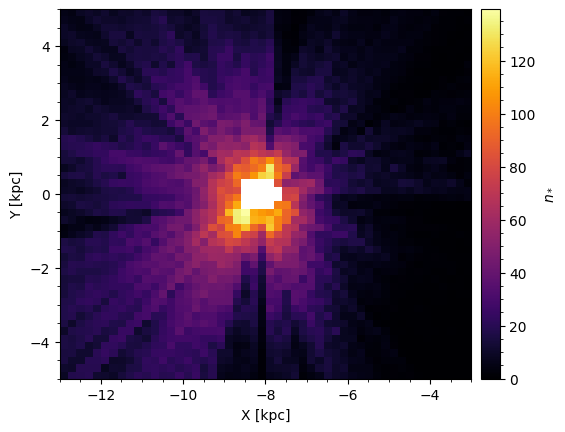

In [11]:
fig, ax = plt.subplots()

image = ax.imshow(get_grid("n_stars"), vmin=0.0, **imshow_defaults)
cax = fig.colorbar(image, ax=ax, pad=0.02, aspect=20, label=r"$n_*$")
cax.minorticks_on()
ax.set(xlabel="X [kpc]", ylabel="Y [kpc]", aspect="auto")
ax.minorticks_on()

## Detection probability (Fig. 9)

We can look at the detection probability of our cluster across the disk. As expected, it matches up quite a lot with where dust is.

[Text(0.5, 0, 'X [kpc]'), Text(0, 0.5, 'Y [kpc]')]

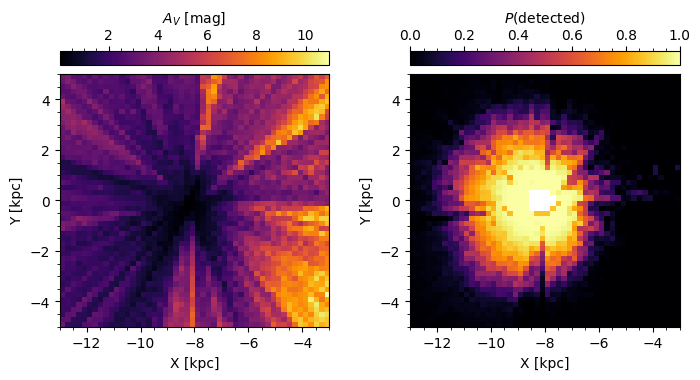

In [12]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2, sharex=True)
fig.subplots_adjust(wspace=0.3)

image = ax[0].imshow(get_grid("extinction"), **imshow_defaults)
cax = fig.colorbar(
    image,
    ax=ax[0],
    pad=0.03,
    orientation="horizontal",
    location="top",
    label=r"$A_V$ [mag]",
)
cax.minorticks_on()

image = ax[1].imshow(
    get_grid("probability_circular"), vmin=0.0, vmax=1.0, **imshow_defaults
)
cax = fig.colorbar(
    image,
    ax=ax[1],
    pad=0.03,
    orientation="horizontal",
    location="top",
    label=r"$P(\mathrm{detected})$",
)
cax.minorticks_on()

for an_ax in ax:
    an_ax.set_aspect("auto")
    an_ax.minorticks_on()

ax[0].set(xlabel="X [kpc]", ylabel="Y [kpc]")
ax[1].set(xlabel="X [kpc]", ylabel="Y [kpc]")

## Detection probability ratio (Fig. 10)

And finally - for the money plot - we can calculate what the ratio in detection probability is between a circular and fast orbit, as a function of cluster position.

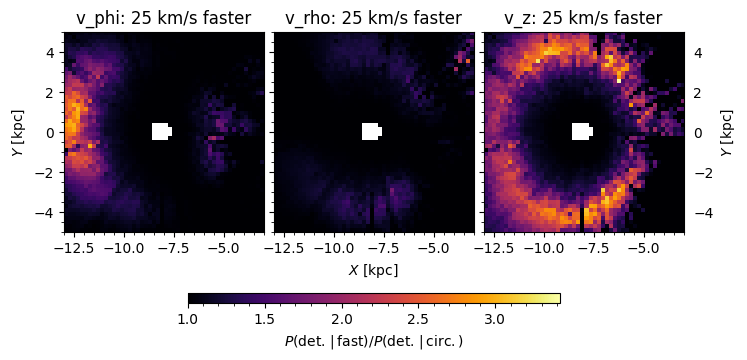

In [13]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=3, sharex=True)
fig.subplots_adjust(wspace=0.05)

# Precalculate ratios so that we can give every plot the same colormap
p_circular = get_grid("probability_circular")
circular_is_zero = (p_circular == 0).nonzero()

# Ignore warnings - div by 0 here is fine, NaN values are handled later properly
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ratios = [get_grid(name) / p_circular for name in orbit_names[1:4]]

# Calculate min/max for colourmap
# Min is set to 1.0 because very occasionally things erroneously dip very low (due to
# random chance), which messes up colour scheme.
min_value = 1.0
max_value = np.nanmax(ratios)

# Add images
for an_ax, col, ratio in zip(ax, orbit_names[1:4], ratios):
    ratio[circular_is_zero] = 1.0  # Handles division by zeros
    image = an_ax.imshow(ratio, vmin=min_value, vmax=max_value, **imshow_defaults)
    an_ax.set_title(
        col.replace("probability_", "").replace("_offset_", ": ") + " km/s faster"
    )

# Add a colour bar
cax = fig.colorbar(
    image,
    ax=ax,
    pad=0.2,
    label=r"$P(\mathrm{det.}\,|\,\mathrm{fast}) / P(\mathrm{det.}\,|\,\mathrm{circ.})$",
    orientation="horizontal",
    location="bottom",
    aspect=40,
    shrink=0.6,
)
cax.minorticks_on()

# Beautification
# Aspects & minorticks on
for an_ax in ax:
    an_ax.set_aspect("auto")
    an_ax.minorticks_on()

# Axis labels
ax[0].set_ylabel("$Y$ [kpc]")
ax[-1].set_ylabel("$Y$ [kpc]")
ax[1].set_xlabel("$X$ [kpc]")

# Configure ticks
for an_ax in ax[1:-1]:
    an_ax.tick_params(labelleft=False, labelright=False)
ax[-1].tick_params(labelright=True, labelleft=False)
ax[-1].yaxis.set_label_position("right")

So that's it! This notebook shows you how to reproduce our favourite figure from the paper. Armed with this information, we hope you can do cool things with our work.